In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Read dataset
train_path = "/home/hgq/Projects/DLFA3/dataset/Google_Stock_Price_Train.csv"
test_path = "/home/hgq/Projects/DLFA3/dataset/Google_Stock_Price_Test.csv"
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
features = ['Open', 'High', 'Low', 'Close', 'Volume']
train_data = train_data[features]
test_data = test_data[features]

# Transform to float
for column in features:
    if train_data[column].dtype == 'object':
        train_data[column] = train_data[column].str.replace(',', '').astype(float)
    if test_data[column].dtype == 'object':
        test_data[column] = test_data[column].str.replace(',', '').astype(float)

# Combine train and test datasets
combined_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
combined_scaled = scaler.fit_transform(combined_data)

# Look-back window size
look_back = 60

# Create input-output pairs
X, y = [], []
for i in range(look_back, len(combined_scaled)):
    X.append(combined_scaled[i - look_back:i])  # Input: Previous `look_back` days
    y.append(combined_scaled[i])               # Output: the data of the current day
X = np.array(X)
y = np.array(y)

# Split into train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_end = int(len(X) * train_ratio)
val_end = train_end + int(len(X) * val_ratio)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# Output shapes
print(f"X_train={X_train.shape}, y_train={y_train.shape}")
print(f"X_val={X_val.shape}, y_val={y_val.shape}")
print(f"X_test={X_test.shape}, y_test={y_test.shape}")


X_train=(852, 60, 5), y_train=(852, 5)
X_val=(182, 60, 5), y_val=(182, 5)
X_test=(184, 60, 5), y_test=(184, 5)


In [2]:
print(print(X_train))

[[[0.08256815 0.09205692 0.08685134 0.23757287 0.29525831]
  [0.09334336 0.09391162 0.09432692 0.24151427 0.22993592]
  [0.0907659  0.08834754 0.09034359 0.22878051 0.26361233]
  ...
  [0.07549804 0.0754717  0.07522872 0.21546794 0.14593512]
  [0.07730584 0.07903841 0.07999418 0.21229828 0.16105326]
  [0.08176269 0.08356814 0.08566907 0.22430164 0.20379656]]

 [[0.09334336 0.09391162 0.09432692 0.24151427 0.22993592]
  [0.0907659  0.08834754 0.09034359 0.22878051 0.26361233]
  [0.08809895 0.08481649 0.08450499 0.21641884 0.21617942]
  ...
  [0.07730584 0.07903841 0.07999418 0.21229828 0.16105326]
  [0.08176269 0.08356814 0.08566907 0.22430164 0.20379656]
  [0.08301563 0.08178478 0.07953946 0.21420007 0.15438526]]

 [[0.0907659  0.08834754 0.09034359 0.22878051 0.26361233]
  [0.08809895 0.08481649 0.08450499 0.21641884 0.21617942]
  [0.07682257 0.07326033 0.05864057 0.1785483  0.46779736]
  ...
  [0.08176269 0.08356814 0.08566907 0.22430164 0.20379656]
  [0.08301563 0.08178478 0.0795394

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tansform to PyTorch Tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

# LSTM
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out

# Initialize
input_size = 5  # Input 5 features
hidden_size = 32
num_layers = 2
output_size = 5  # Predict 5 features
model = MyLSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Loss Function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training
num_epochs = 50
batch_size = 32

X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

# Early Stopping 
patience = 5  
best_val_loss = float('inf') 
early_stop_counter = 0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        # Forward
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        train_loss += loss.item()
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(X_train) / batch_size  # Train Loss

    # Evaluate
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early Stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss 
        early_stop_counter = 0  
        # Save Best Model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1
        print(f"Validation loss did not improve. Early stop counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

# Load Best Model
model.load_state_dict(torch.load("best_model.pth"))


Epoch [1/50], Train Loss: 0.1308, Val Loss: 0.2871
Epoch [2/50], Train Loss: 0.0478, Val Loss: 0.0484
Epoch [3/50], Train Loss: 0.0421, Val Loss: 0.0494
Validation loss did not improve. Early stop counter: 1/5
Epoch [4/50], Train Loss: 0.0327, Val Loss: 0.0330
Epoch [5/50], Train Loss: 0.0301, Val Loss: 0.0195
Epoch [6/50], Train Loss: 0.0264, Val Loss: 0.0081
Epoch [7/50], Train Loss: 0.0223, Val Loss: 0.0043
Epoch [8/50], Train Loss: 0.0203, Val Loss: 0.0044
Validation loss did not improve. Early stop counter: 1/5
Epoch [9/50], Train Loss: 0.0195, Val Loss: 0.0081
Validation loss did not improve. Early stop counter: 2/5
Epoch [10/50], Train Loss: 0.0181, Val Loss: 0.0257
Validation loss did not improve. Early stop counter: 3/5
Epoch [11/50], Train Loss: 0.0137, Val Loss: 0.0257
Validation loss did not improve. Early stop counter: 4/5
Epoch [12/50], Train Loss: 0.0117, Val Loss: 0.0218
Validation loss did not improve. Early stop counter: 5/5
Early stopping triggered.


<All keys matched successfully>

Open - MSE: 0.0155, MAE: 0.1141, R²: -2.7550


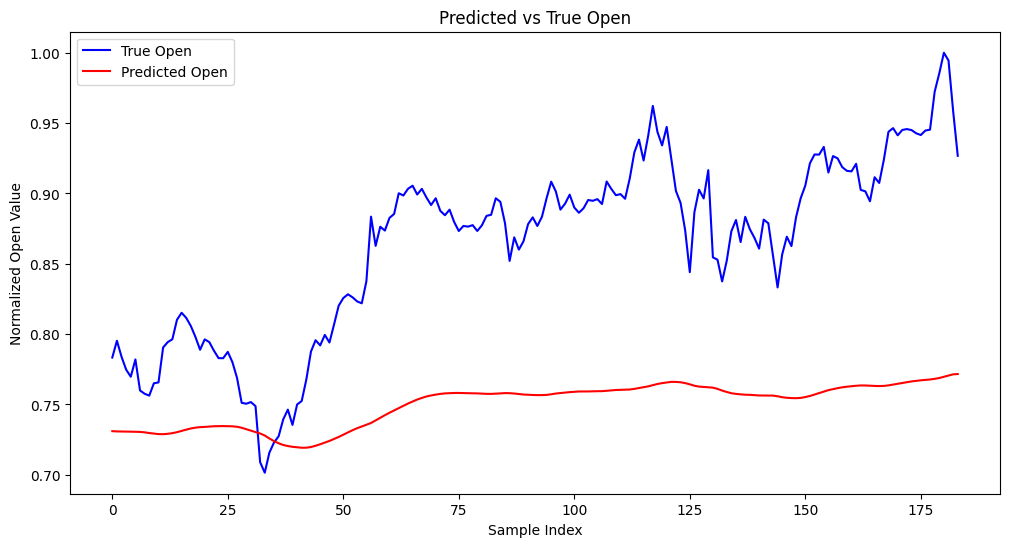

High - MSE: 0.0074, MAE: 0.0752, R²: -0.8290


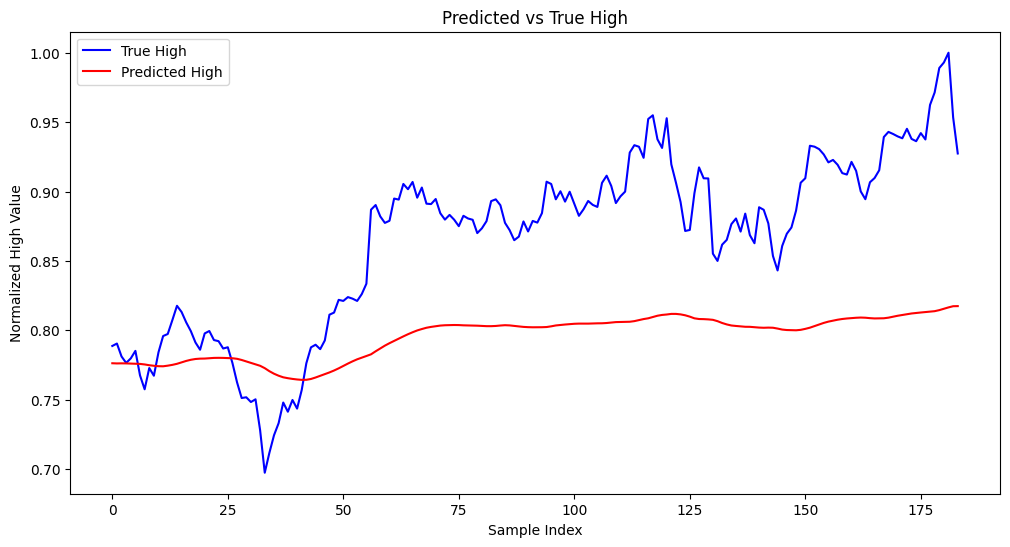

Low - MSE: 0.0036, MAE: 0.0517, R²: 0.1495


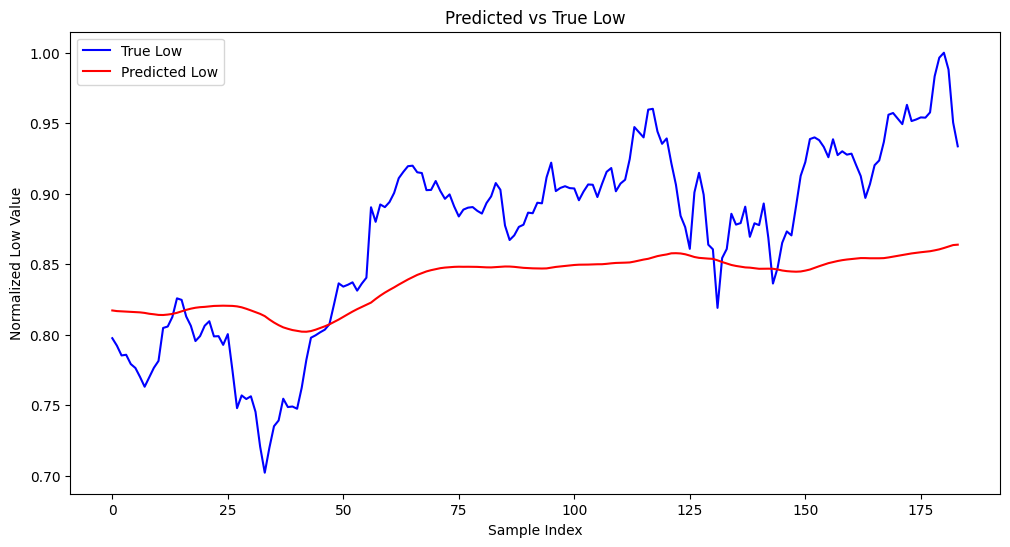

Close - MSE: 0.0020, MAE: 0.0378, R²: 0.1828


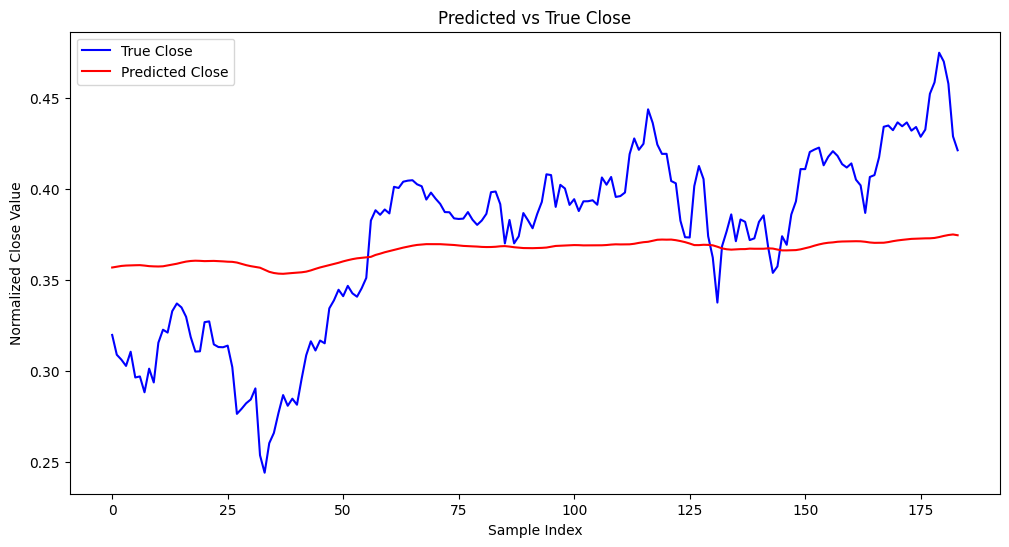

Volume - MSE: 0.0013, MAE: 0.0324, R²: -0.7612


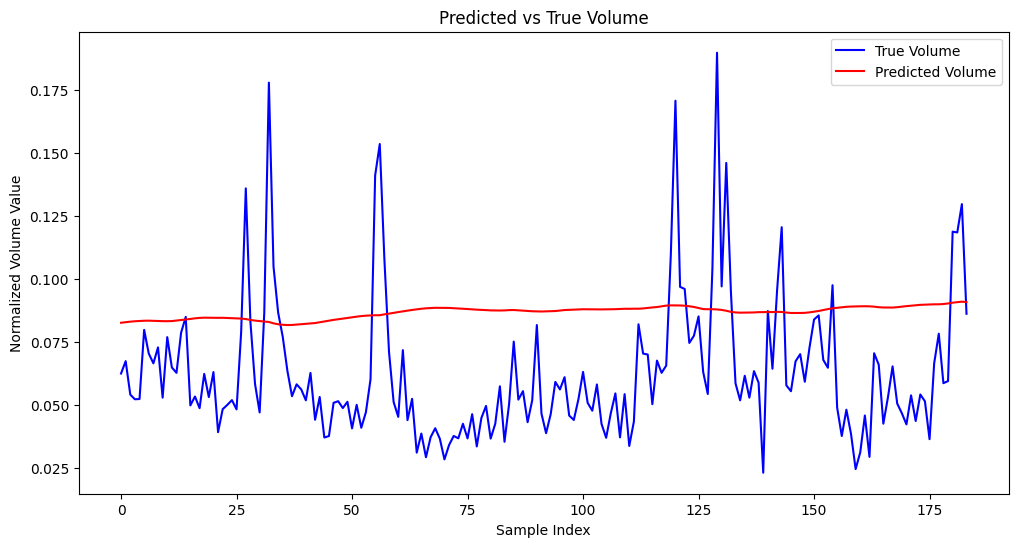


Overall Metrics (All Features):
Mean Squared Error (MSE): 0.0059
Mean Absolute Error (MAE): 0.0622
R² Score: -0.8026


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Test
model.eval()

# Transform to PyTorch Tensor
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

with torch.no_grad():
    predictions = model(X_test)

# Transform prediction and true to NumPy
predictions = predictions.cpu().numpy()
y_test = y_test.cpu().numpy()

features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Calculate metrics
for i, feature in enumerate(features):
    mse = mean_squared_error(y_test[:, i], predictions[:, i])
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    r2 = r2_score(y_test[:, i], predictions[:, i])
    print(f"{feature} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Plot Charts
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, i], label=f"True {feature}", color="blue")
    plt.plot(predictions[:, i], label=f"Predicted {feature}", color="red")
    plt.title(f"Predicted vs True {feature}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"Normalized {feature} Value")
    plt.legend()
    plt.show()

# Total Metrics
mse_total = mean_squared_error(y_test, predictions)
mae_total = mean_absolute_error(y_test, predictions)
r2_total = r2_score(y_test, predictions)

print("\nOverall Metrics (All Features):")
print(f"Mean Squared Error (MSE): {mse_total:.4f}")
print(f"Mean Absolute Error (MAE): {mae_total:.4f}")
print(f"R² Score: {r2_total:.4f}")
